## _Track Performance_

Note: We can't find Purity/Fake Rate and Duplication Rate from the _`particles.h5`_ with current variables we have.

In [1]:
import glob, os, sys, yaml

In [2]:
import math, time
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial
from utils_plot import make_cmp_plot, pt_configs, eta_configs, get_ratio

In [4]:
sys.path.append('..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### _Read Particles HDF5 Store_

- To consistent with resutls, we chose $MF > 50\%$, Minimum True Hits $\ge 7$ STT hits for reconstructable particles, and Minimum Reco Hits $\ge 5, 6$ for reconstucted tracks.

In [5]:
# MF >50%, Functor: >= 7 STT hits, and Min Reco. Hits 5 STT hits
# path = "../run_all/dnn_segmenting_ln/eval/0.5_7_5_particles.h5"
# path = "../run_all/gnn_segmenting/eval/0.5_7_5_particles.h5"
path = "../run_all/fwp_gnn_segmenting/eval/0.5_7_5_particles.h5"

In [6]:
# load HDFStore
store = pd.HDFStore(path)

In [7]:
# store.get('data').head()
df = store['data']

In [8]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,6,0.205157,-1.854500,-0.415320,8.052530,1,2212,0.211190,2.244420,2.951081,8,True,True,0
1,5,0.128648,2.395160,0.536402,6.411090,1,211,0.991597,0.614596,-0.528416,16,True,True,0
0,5,0.101602,-1.338330,1.013940,8.682130,1,211,0.374578,1.663314,1.566344,11,True,True,1
1,6,0.275242,0.134011,-0.101529,0.468718,1,2212,0.473503,1.421811,-0.582538,14,True,True,1
0,5,0.114144,1.320080,0.160395,18.215401,1,211,0.503124,1.358655,-0.031754,23,True,True,10


In [9]:
outdir = "./"
out_prefix = "piminus"

In [10]:
# Filtering: We can filter charge, pdgcode vs Tracking efficiency, OR see fiducial cuts
# df = df[df['pdgcode'].isin([-211, 211])].reset_index(drop=True)
# df = df[df['pdgcode'].isin([-2212, 2212])].reset_index(drop=True)
df = df[df['pdgcode'].isin([-211])].reset_index(drop=True)  # pbar=-2212, p=2212, piplus=211, piminus=-211
# df = df[df['q'] == 1].reset_index(drop=True)

In [11]:
pt = df.pt.values

vx = df.vx.values
vy = df.vy.values
d0 = np.sqrt(vx**2 + vy**2)
z0 = df.vz.values

charge = df.q
pdgcode = df.pdgcode

peta = df.peta.values
ptheta = (df.ptheta.values*180)/np.pi   # radians to degrees
pphi = (df.pphi.values*180)/np.pi       # radians to degrees

matched_idx = df.is_matched             # matched
rectable_idx = df.is_trackable          # reconstructable

In [12]:
# fiducial cuts: q, pt, eta, phi, particle type, etc.
fiducial = (charge > 0) & (pt > 0.5)

In [13]:
# plot the efficiency as a function of pT, eta
make_cmp_plot_fn = partial(make_cmp_plot,
                           legends=["Selected", "Selected Matched", "Reconstructable", "Reconst. Matched"],
                           ylabel="Particles", ratio_label='Track Efficiency',
                           ratio_legends=["Tracking Efficiency (Phys.)", "Tracking Efficiency (Tech.)"])
                           # ratio_legends=[r"$\epsilon$", r"$\epsilon_{tech.}$"])

### _1. Tranverse Momentum_

In [14]:
min(pt), max(pt)

(0.0036467735, 0.24082041)

In [15]:
pt_min, pt_max = min(pt), max(pt)

# linear scale on x-axis
pt_bins = np.linspace(pt_min, 0.25, num=20)

# log scale on x-axis
# pt_bins = np.logspace(np.log10(pt_min), np.log10(pt_max), 20)

# pt_bins = [0, 0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3] #, 0.35, 0.6]

pt_configs = {
    'bins': pt_bins,
    'histtype': 'step',
    'lw': 1,
    'log': False
}

cut_pt: 0.0


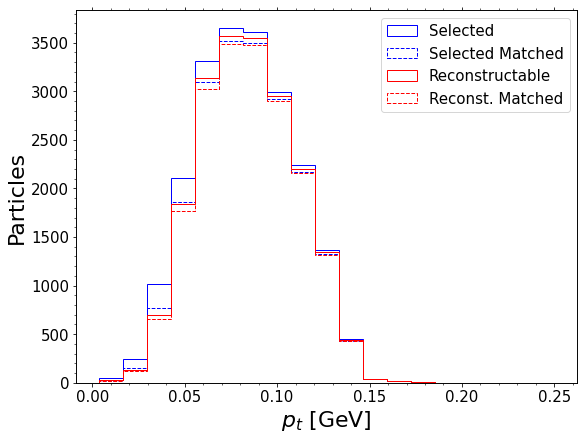

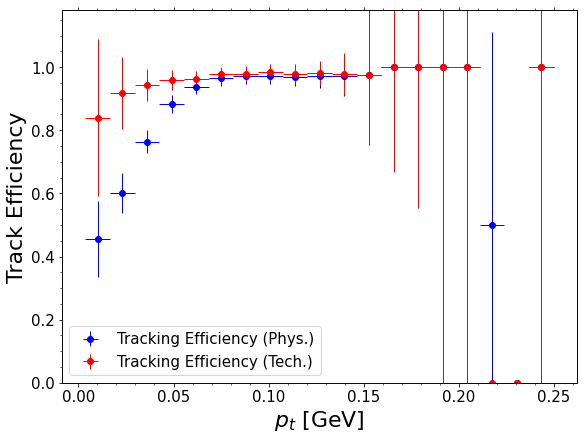

In [16]:
# vertex cuts
all_cuts = [0.0]

for (cut_pt) in all_cuts:
    print("cut_pt: {}".format(cut_pt))

    cuts = (pt > cut_pt)

    # make pt plots
    sel_particles = pt[cuts]                                        # selected/generated
    sel_matched_particles = pt[cuts & matched_idx]                  # selected and matched
    reco_particles = pt[cuts & rectable_idx]                        # selected and reconstructable
    reco_matched_particles = pt[cuts & rectable_idx & matched_idx]  # selected, reconstructable and matched
    
    # print("efficiency (phys.): ", (sel_matched_particles.shape[0]/sel_particles.shape[0]*100))
    # print("efficiency (tech.): ", (reco_matched_particles.shape[0]/reco_particles.shape[0]*100))
    
    make_cmp_plot_fn([sel_particles, sel_matched_particles, reco_particles, reco_matched_particles], 
        configs=pt_configs, xlabel=r"$p_t$ [GeV]",
        outname=os.path.join(outdir, "{}_pt_cut{}".format(out_prefix, cut_pt)),
        ymin=0.0, loc='upper right')

### _2. Theta Angle_

In [17]:
min(ptheta), max(ptheta)

(5.7223797, 157.69539)

In [18]:
ptheta_min, ptheta_max = min(ptheta), max(ptheta)

# linear scale on x-axis
ptheta_bins = np.linspace(22, ptheta_max, num=15)

# log scale on x-axis
# ptheta_bins = np.logspace(np.log10(ptheta_min), np.log10(ptheta_max), 20)

# ptheta_bins = [22, 28, 34, 40, 46, 52, 58, 64, 74, 84, 92, 105, 120, 142]

ptheta_configs = {
    'bins': ptheta_bins,
    'histtype': 'step',
    'lw': 1,
    'log': False
}

### _3. Phi Angle_

In [19]:
min(pphi), max(pphi)

(-179.98633, 179.98715)

In [20]:
pphi_min, pphi_max = min(pphi), max(pphi)

# linear scale on x-axis
pphi_bins = np.linspace(-180, 180, num=15)

pphi_configs = {
    'bins': pphi_bins,
    'histtype': 'step',
    'lw': 1,
    'log': False
}

### _4. Decay Vertex_

In [21]:
min(d0), max(d0)

(6.545823e-05, 20.188238)

In [22]:
d0_min, d0_max = min(d0), max(d0)

# linear scale on x-axis
d0_bins = np.linspace(d0_min, 15, num=15)   # will give 15 bins

# log scale on x-axis
# ptheta_bins = np.logspace(np.log10(ptheta_min), np.log10(ptheta_max), 20)

# d0_bins = [0., 1.1, 2.15, 3.2, 4.0, 5.3, 6.5, 7.5, 8.5, 9.5, 10.7, 12, 15]

d0_configs = {
    'bins': d0_bins,
    'histtype': 'step',
    'lw': 1,
    'log': False
}

___
## _Recreate the Summary from Track Evalution Script_

In [23]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,7,0.034445,-0.508384,-0.287402,1.729510,-1,-211,0.223010,2.189529,1.487519,7,True,True,100
1,7,0.060946,2.234620,-3.131190,10.429100,-1,-211,0.538004,1.288500,2.467306,23,True,True,1000
2,7,0.082656,-0.960572,0.003573,2.532590,-1,-211,0.579633,1.209948,2.071954,21,True,True,10000
3,7,0.094969,-0.451167,0.621240,2.429670,-1,-211,0.752346,0.928915,1.558436,16,True,True,10001
4,7,0.079381,0.078332,-0.093677,0.952623,-1,-211,0.511013,1.342409,-2.414122,20,True,True,10002


In [24]:
# Lets find Phys. and Tech. Efficicencies
sel_particles = df                                        # selected/generated
sel_matched_particles = df[matched_idx]                   # selected and matched
reco_particles = df[rectable_idx]                         # selected and reconstructable
reco_matched_particles = df[rectable_idx & matched_idx]   # selected, reconstructable and matched

In [25]:
sel_particles.shape[0], sel_matched_particles.shape[0], reco_particles.shape[0], reco_matched_particles.shape[0]

(21103, 19843, 19958, 19426)

- _Physics Efficiency_

In [26]:
# Physics Efficiency = (sel, matched)/sel
print("efficiency (phys.): {:>3.2f}%".format(sel_matched_particles.shape[0]/sel_particles.shape[0]*100))

efficiency (phys.): 94.03%


In [27]:
n_sel_particles = df.shape[0]
n_matched_sel_particles = df[df.is_matched].shape[0]
print("Tracking Efficiency (Phys.): {:>3.2f}%".format(100 * n_matched_sel_particles/n_sel_particles))

Tracking Efficiency (Phys.): 94.03%


- _Technical Efficiency_

In [28]:
# Technical Efficiency = (sel, reconstructable, matched)/(sel, reconstructable)
print("efficiency (tech.): {:>3.2f}%".format(reco_matched_particles.shape[0]/reco_particles.shape[0]*100))

efficiency (tech.): 97.33%


## _Efficiency Difference Between Positive and Negative Charge_

- Lets plot difference of overall tracking efficiences for positive and negative charges.

In [29]:
# fiducial cut on charge
fiducial_pos = (charge > 0)
fiducial_neg = (charge < 0)

In [30]:
def sel_particles(var, fiducial):
    sel_particles = var[fiducial]                                        # selected/generated
    sel_matched_particles = var[fiducial & matched_idx]                  # selected and matched
    return sel_particles, sel_matched_particles

In [31]:
def reco_particles(var, fiducial):
    reco_particles = var[fiducial & rectable_idx]                        # selected and reconstructable
    reco_matched_particles = var[fiducial & rectable_idx & matched_idx]  # selected, reconstructable and matched
    return reco_particles, reco_matched_particles

- Difference in overall efficiency

In [32]:
pt = df.pt

In [33]:
sel, sel_matched = sel_particles(pt, fiducial_pos)

sel_vals, sel_bins = np.histogram(sel, bins=pt_bins)
sel_match_vals, sel_match_bins = np.histogram(sel_matched, bins=pt_bins)

eff1, err1 = get_ratio(sel_match_vals, sel_vals)
xvals1 = (sel_bins[1:] + sel_bins[:-1]) / 2
xerrs1 = (sel_bins[1:] - sel_bins[:-1]) / 2

In [34]:
sel, sel_matched = sel_particles(pt, fiducial_neg)

sel_vals, sel_bins = np.histogram(sel, bins=pt_bins)
sel_match_vals, sel_match_bins = np.histogram(sel_matched, bins=pt_bins)

eff2, err2 = get_ratio(sel_match_vals, sel_vals)
xvals2 = (sel_bins[1:] + sel_bins[:-1]) / 2
xerrs2 = (sel_bins[1:] - sel_bins[:-1]) / 2

In [35]:
xvals = [e1 - e2 for (e1, e2) in zip(xvals1, xvals2)]
xerrs = [e1 - e2 for (e1, e2) in zip(xerrs1, xerrs2)]
eff = [e1 - e2 for (e1, e2) in zip(eff1, eff2)]
err = [math.sqrt(e1**2 + e2**2) for (e1, e2) in zip(err1, err2)]

### _Plotting Efficiency_

In [36]:
store.close()